In [30]:
import numpy as np
import matplotlib.pyplot as plt

##### Task: Identify key connectors among data scientists in a network

We have the data, a list of users held in a dict that contains user's id (integer) and name (string)

keys: "id" & "name"

and friendship data: a list of tuples (a,b) where a=id of scientist and b=id friend of that scientist. We can think of friendship pairs as a network.

In [2]:
users = [
{ "id": 0, "name": "Hero" },
{ "id": 1, "name": "Dunn" },
{ "id": 2, "name": "Sue" },
{ "id": 3, "name": "Chi" },
{ "id": 4, "name": "Thor" },
{ "id": 5, "name": "Clive" },
{ "id": 6, "name": "Hicks" },
{ "id": 7, "name": "Devin" },
{ "id": 8, "name": "Kate" },
{ "id": 9, "name": "Klein" }
]

friendship_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
(4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

We want to create a dict where the keys are user ids and values are lists of friends ids. This way we dont have to iterate over the pairs to find friends of a certain user.

In [3]:
#initialize the empty dict
friendships = {user['id']: [] for user in users} #create dict with keys "id" and value []
print(friendships)

#and populate it from friendship pairs
for i, j in friendship_pairs:
    friendships[i].append(j)
    friendships[j].append(i)
    
print(friendships)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
{0: [1, 2], 1: [0, 2, 3], 2: [0, 1, 3], 3: [1, 2, 4], 4: [3, 5], 5: [4, 6, 7], 6: [5, 8], 7: [5, 8], 8: [6, 7, 9], 9: [8]}


can now ask  whats the average number of connections by first finding the total number of connections. To do this we need to sum the lengths of the populated friend's lists

In [4]:
def number_of_friends(user):
    return len(friendships[user["id"]])

total_connections = sum(number_of_friends(user) for user in users)
print(total_connections)

total2 = sum(len(friendships[user["id"]]) for user in users)
print(total2)

avg = total2/len(users)

24
24


Now we want to find the "most connected" people with the greatest number of friends

In [6]:
#We want to create a list of people with their friends
num_friends_by_id = [(user["id"], number_of_friends(user)) for user in users]

#and sort from largest to smallest
#print(num_friends_by_id)
num_friends_by_id.sort(key=lambda x:x[1], reverse=True)
#sort by key which is num_friends_id[1] ie the number of friends in the list
print(num_friends_by_id)

[(1, 3), (2, 3), (3, 3), (5, 3), (8, 3), (0, 2), (4, 2), (6, 2), (7, 2), (9, 1)]


Now we'll design a simple recommendation algorithm based on suggesting friends of friends

How can we do this? lets iterate over the friends and collect the friends of friends. Then we'll ad a count of mutual friends. 

In [20]:
print(friendships)

def foaf_ids_bad(user):
    #return a list populated by friends of friends
    return [foaf_id 
            for friend_id in friendships[user["id"]] #select friend list in friendships
            for foaf_id in friendships[friend_id]] #select id's of friends in list a populate return list

print(foaf_ids_bad(users[0])) #returns all friends of users[0]

#then add a count of mutual friends and exclude people already known to the user

from collections import Counter
def friends_of_friends(user):
    user_id = user["id"]
    return Counter(foaf_id
                  for friend_id in friendships[user_id]
                  for foaf_id in friendships[friend_id]
                  #don't add to count if user_id is that friend and if the friend has already been counted
                  if foaf_id != user_id and foaf_id not in friendships[user_id])

print(friends_of_friends(users[3])) #tells us users[3] has 2 friends in common with zero and 1 with five

{0: [1, 2], 1: [0, 2, 3], 2: [0, 1, 3], 3: [1, 2, 4], 4: [3, 5], 5: [4, 6, 7], 6: [5, 8], 7: [5, 8], 8: [6, 7, 9], 9: [8]}
[0, 2, 3, 0, 1, 3]
Counter({0: 2, 5: 1})


Now we want to suggest meeting users from similar interest. We have the following data of the user_id and their top interest. We start by defining a function that finds users witha a certain interest.

In [26]:
interests = [
(0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
(0, "Spark"), (0, "Storm"), (0, "Cassandra"),
(1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
(1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
(2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"),
(3, "statistics"), (3, "regression"), (3, "probability"),
(4, "machine learning"), (4, "regression"), (4, "decision trees"),
(4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"),
(5, "Haskell"), (5, "programming languages"), (6, "statistics"),
(6, "probability"), (6, "mathematics"), (6, "theory"),
(7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"),
(7, "neural networks"), (8, "neural networks"), (8, "deep learning"),
(8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"),
(9, "Java"), (9, "MapReduce"), (9, "Big Data")
]

def data_like(target_interest):
    return [user_id for user_id, user_interest in interests
           if user_interest==target_interest]

#this works but has to examine the whole list of interest for every search
#we build an index from interests to users for ease of repitition

from collections import defaultdict

user_ids_by_interest = defaultdict(list)
for user_id, interest in interests:
    user_ids_by_interest[interest].append(user_id)

#print(user_ids_by_interest)

#and another from users to interests
interests_by_user_id = defaultdict(list)
for user_id, interest in interests:
    interests_by_user_id[user_id].append(interest)

print(interests_by_user_id)
    
#now we can find who has the most interests in common with a given user
#we iterate over a user's interests
#then for each interest, iterate over the other users with that interest
#keep count of how many times we see the other user

def most_common_interests_with(user):
    return Counter(int_user_id
                   for interest in interests_by_user_id[user["id"]] #iterate through interests
                   for int_user_id in user_id_by_interests[interest] #iterate through users with interests
                   if int_user_id != user['id']) #conditional to exclude the user input of the function
                   
#use further in chapter 23

defaultdict(<class 'list'>, {0: ['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra'], 1: ['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres'], 2: ['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas'], 3: ['R', 'Python', 'statistics', 'regression', 'probability'], 4: ['machine learning', 'regression', 'decision trees', 'libsvm'], 5: ['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages'], 6: ['statistics', 'probability', 'mathematics', 'theory'], 7: ['machine learning', 'scikit-learn', 'Mahout', 'neural networks'], 8: ['neural networks', 'deep learning', 'Big Data', 'artificial intelligence'], 9: ['Hadoop', 'Java', 'MapReduce', 'Big Data']})


###### Task: Salaries and Experience

We have data that is salaries (integer) and tenure (float) for different scientists as a list of tuples we want to do some general analysis>

{8.7: 83000.0, 8.1: 88000.0, 0.7: 48000.0, 6: 76000.0, 6.5: 69000.0, 7.5: 76000.0, 2.5: 60000.0, 10: 83000.0, 1.9: 48000.0, 4.2: 63000.0}


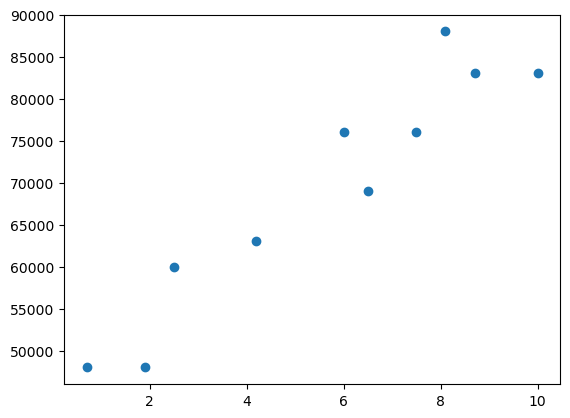

In [54]:
salaries_and_tenures = [(83000, 8.7), (88000, 8.1),
(48000, 0.7), (76000, 6),
(69000, 6.5), (76000, 7.5),
(60000, 2.5), (83000, 10),
(48000, 1.9), (63000, 4.2)]

#start by plotting
x,y = [], []
for i in range(len(salaries_and_tenures)):
    x.append(salaries_and_tenures[i][1])
    y.append(salaries_and_tenures[i][0])
plt.scatter(x,y)

#people with more experience earn more
#we first look at average salary for each tenure

salary_by_tenure = defaultdict(list) #Initialize empty dict like object

for salary, tenure in salaries_and_tenures: #Iterate through dataset and fill dict
    salary_by_tenure[tenure].append(salary)
    
#new dict populated by tenure as key and avg salaries as values
avg_salary_by_tenure = {tenure:sum(salaries) / len(salaries)
                       for tenure, salaries in salary_by_tenure.items()}
print(avg_salary_by_tenure)

In [61]:
#this isn't super helpful since none of the uses have the same tenure
#we organize through binning tenure

def tenure_bin(tenure):
    if tenure <2:
        return "less than two"
    elif tenure <5:
        return "between two and five"
    else:
        return "more than five"
    
#and group salaries by each bucket
sal_by_ten = defaultdict(list)
for salary, tenure in salaries_and_tenures:
    bucket = tenure_bin(tenure)
    sal_by_ten[bucket].append(salary)

print(sal_by_ten)
#and compute average salary for the group
avg_salary_by_bin = {tenure_bin: sum(salaries)/len(salaries)
                    for tenure_bin, salaries in sal_by_ten.items()}
print('--')
print(avg_salary_by_bin)

#now we can compare and make an analysis like scientists with 5 or more years of
#experience make on average 65% more

defaultdict(<class 'list'>, {'more than five': [83000, 88000, 76000, 69000, 76000, 83000], 'less than two': [48000, 48000], 'between two and five': [60000, 63000]})
--
{'more than five': 79166.66666666667, 'less than two': 48000.0, 'between two and five': 61500.0}
